# Immunotherapy response prediction

Data available here: https://docs.google.com/spreadsheets/d/18xh2RB6dZnhv4L5zAyroxtVYr5GVMrEO_itAu5qis70/edit#gid=0

## Table of Contents:
* [1. Project Description](#project-description)
* [2. Data Loading](#data-loading)
* [3. Data Exploration](#data-exploration)
* [4. Log Fold Changes analysis](#log-fold-change-analysis)
* [5. Survival analysis](#survival-analysis)
* [6. Modeling](#modeling)

## 1. Project Description <a class="anchor" id="project-description"></a>

The main objective is once data have been processed, looking for immunophenotypic markers associated to response in immunotherapy.

## 1.1 Package importing and reproducibility summary

In [3]:
import os, sys, warnings
warnings.filterwarnings('ignore')

In [4]:
### rasbt watermark https://github.com/rasbt/watermark
%load_ext watermark
%watermark -a 'Fernando Pozo' -u -n -t -z -g -p pandas,numpy,matplotlib,seaborn,scipy,sklearn,missingno

### magic functions
%load_ext autoreload
%autoreload 2

!pwd

Fernando Pozo 
last updated: Wed Apr 29 2020 11:48:10 CEST 

pandas 1.0.3
numpy 1.18.1
matplotlib 3.2.0
seaborn 0.10.0
scipy 1.4.1
sklearn 0.0
missingno 0.4.2
Git hash: b62a90c1288c349b7383982d34cba6e01f5a7603
/local/fpozoc/MEGA/projects/immunotherapy-response/notebooks


In [67]:
### 3rd party libraries
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from scipy.stats import shapiro
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from IPython.display import clear_output

In [2]:
from pandas_profiling import ProfileReport

In [3]:
### custom libraries
sys.path.append('../src/')
from utils import (generate_scores, get_columns, get_corr, 
                   make_comparison, make_stats_paired_comparisons, 
                   mwu_compare, process_patients, scoring_metrics, vis_volcano)

## 2. Data Loading <a class="anchor" id="data-loading"></a>

The first objective was to establish a group of study and a group of control patients. Our dataset contains **40 patients treated with immunotherapy** (15 responded, and 25 not responded), **39 patients treated with chemotherapy** (14 responded, and 25 not responded), and 4 healthy controls.

In [5]:
df, df_controls = process_patients('../data/table_immr - data.csv')
df_it = df.loc[df['r:treatment_inmunotherapy'] == 1]
df_qt = df.loc[df['r:treatment_inmunotherapy'] == 0]

In [6]:
clinical_variables = get_columns(df, 'b:', loc='start') + get_columns(df, 'c:', loc='start') + get_columns(df, 'i:', loc='start') + get_columns(df, 'r:', loc='start') + get_columns(df, 's:', loc='start') + get_columns(df, 'v:', loc='start') # Clinical variables
basal_markers = get_columns(df[get_columns(df, pattern='IF', loc='start')], pattern='_1', loc='end')

## 3. Data Exploration <a class="anchor" id="data-exploration"></a>

Missing data in patients treated with Immunotherapy. Only basal determination showed. 2nd determination has a lot of missing values.

In [40]:
msno.matrix(df.loc[df['r:treatment_inmunotherapy'] == 1].drop([col for col in df if col.endswith('_2')], axis=1))

### 3.1 Pairwise Correlations

The pairwise correlation was stored in [corr_response.csv]('../results/correlations/corr_response.csv'). 

Variables compared among the rest: 
- `r:response` (categorical).
- `r:progression_free_survival` (continouos).
- `r:overal_survival` (continouos).
- `i:irae` (categorical).

In [41]:
df_it_no2 = df_it.drop(get_columns(df[get_columns(df, pattern='IF', loc='start')], pattern='_2', loc='end'), axis=1)
corr_r = get_corr(df_it_no2, col='r:response', method='kendall').sort_values(by='index').set_index('index')
corr_os = get_corr(df_it_no2, col='r:progression_free_survival', method='pearson').sort_values(by='index').set_index('index')
corr_pfs = get_corr(df_it_no2, col='r:overall_survival', method='pearson').sort_values(by='index').set_index('index')
corr_irae = get_corr(df_it_no2, col='i:irae', method='kendall').sort_values(by='index').set_index('index')

corrs = pd.concat([corr_r, corr_os, corr_pfs, corr_irae], axis=1)
corrs.to_csv('../results/correlations/corr_response.csv')

### 3.2 Pairplots in immunotherapy patients

A pairplot plots a pairwise relationships in a dataset. We have selected 5 variables to compare what's happening facing with themshelves and the other 4 variables in the comparison.

#### 3.2.1 Pairplot (response)

The diagonal plots show that distribution between positive (orange) and negative (blue) response is different in `r:progression_free_survival` and `r:overall_survival` and slightly different in the other features. However, the points are not drawing differences between responders and non responders.

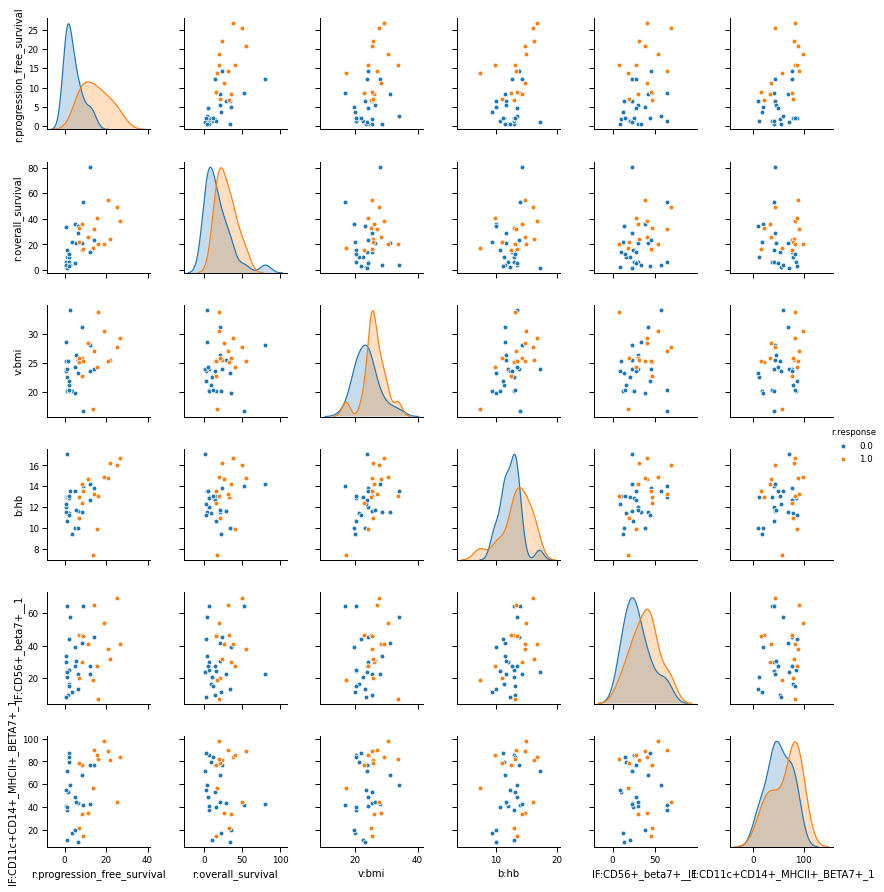

In [42]:
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":10,"axes.labelsize":10})   
p = sns.pairplot(df_it[['r:progression_free_survival', 'r:overall_survival', 'v:bmi', 'b:hb', 'IF:CD56+_beta7+__1', 'IF:CD11c+CD14+_MHCII+_BETA7+_1', 'r:response']], hue="r:response")
p.fig.set_size_inches(12,12)
p.savefig('../results/correlations/pairplot.png', dpi=360)

#### 3.2.2 Pairplot tracing regression

In [43]:
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":10,"axes.labelsize":10})   
p = sns.pairplot(df_it[['r:progression_free_survival', 'r:overall_survival', 'v:bmi', 'b:hb', 'IF:CD56+_beta7+__1', 'IF:CD11c+CD14+_MHCII+_BETA7+_1']], kind='reg')
p.fig.set_size_inches(12,12)
p.savefig('../results/correlations/regplot.png', dpi=360)

### 3.3 Normality test

In [45]:
for col in get_columns(df, pattern='IF'):
    clear_output(wait=True)
    print('-'*10)
    print(col)
    x = df[col].dropna().values
    stat, p = shapiro(x)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

----------
IF:ratio_CD4-CD8_2
Statistics=0.900, p=0.001
Sample does not look Gaussian (reject H0)


## 3.4 Descriptive statistics 

In [14]:
profile_all = ProfileReport(df.drop(get_columns(df, 'IF:', loc='start'), axis=1), title="Complete data set of patients")

In [16]:
profile_it = ProfileReport(df_it.drop(get_columns(df, 'IF:', loc='start'), axis=1), title="Immunotherapy patients")

In [18]:
profile_all.to_file(output_file="../results/reports/processed_db_profile.all_patients.html")
profile_it.to_file(output_file="../results/reports/processed_db_profile.it_patients.html")

## 4. Log fold change analysis <a class="anchor" id="log-fold-change-analysis"></a>

Fold change is a measure describing how much a quantity changes between an original and a subsequent measurement. 

- First, we have plotted in the y-axis the negative $\log_{10}$ of the p-values (threshold was p-val<0.05 or $-\log_{10}$ p-value>-1.3). Each of the p-values represent a [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) between basal and second determination of each immunophenotypic marker. 
- The x-axis represent the difference between the $\log_{2}$ mean of the each of the cases (second determination) and the $\log_{2}$ mean of each of the controls (basal determination). Threshold was set to be higher than 1 or lower than -1.
- Finally, we applied a [Benjamini-Hochberg correction](https://www.statisticshowto.com/benjamini-hochberg-procedure/) to controls the [False Discovery Rate](https://en.wikipedia.org/wiki/False_discovery_rate).

Disclaimer: It is important to assume that in any case our data shows strong differences among any of the variables. We can see some statistically significant differenciated markers using the whole data set. (4.1.1). This differences seems to be higher in bigger datasets (4.1.1, 4.1.2) than lower ones (4.1.3, 4.1.4), therefore we can assume that more data is completely necessary here in order to take decissions based on statistics.

## 4.1 Basal vs. second determination fold change comparisons

### 4.1.1 Basal vs. second determination comparisons in the whole data set (IT+QT patients)

In [32]:
df_comp = make_comparison(df,
                         title='Basal vs. 2nd det. in patients',
                         csv_path=f'../results/comparisons/all_patients.csv',
                         png_path=f'../results/comparisons/all_patients.png')

In [54]:
df_comp.sort_values(by='p_value').head(10)

index    stat   p_value  p_value_nofdrcorrection  \
0             IF:CD3+_CD8+_IL17+  1271.0  0.040409                 0.001188   
99               IF:CD19+_CCR9+_  1307.5  0.040409                 0.000971   
97            IF:CD3+_CD8+_CCR9+  1223.0  0.040409                 0.000501   
77               IF:CD19+_CD47+_  1309.0  0.043435                 0.001771   
86            IF:CD3+_CD8+_TSP1+  1318.5  0.043435                 0.002129   
84               IF:CD19+_TSP1+_  1375.0  0.047631                 0.002802   
100           IF:CD3+_CD4+_CCR9+  1413.0  0.054419                 0.003735   
61            IF:CD3+_CD4+_CD47+  1458.0  0.089019                 0.006982   
92               IF:CD56+_TSP1+_  1393.5  0.111292                 0.009820   
87   IF:CD11c+CD14-_MHCII+_GRK2+  1411.5  0.143582                 0.024080   

     -log10(p_value)    log2FC   n_1   n_0  
0           1.393524 -0.998513  47.0  80.0  
99          1.393524  1.020840  48.0  81.0  
97          1.393524  0.853228  46.0  82.0  
77          1.362161  0.210097  48.0  79.0  
86          1.362161  0.338611  46.0  82.0  
84          1.322110  0.322225  48.0  81.0  
100         1.264249  1.200074  48.0  82.0  
61          1.050517  0.099795  48.0  82.0  
92          0.953536  0.515071  47.0  79.0  
87          0.842899  0.352102  46.0  78.0

### 4.1.2 Basal vs. second determination comparisons in IT patients

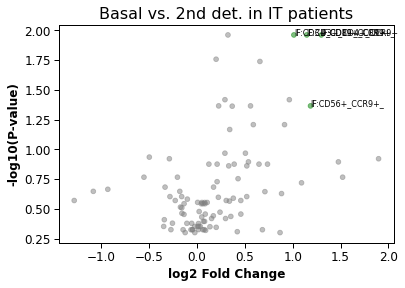

In [42]:
df_comp_it = make_comparison(df_it,
                         title='Basal vs. 2nd det. in IT patients',
                         csv_path=f'../results/comparisons/IT1.csv',
                         png_path=f'../results/comparisons/IT1.png')

In [46]:
df_comp_it.sort_values(by='p_value').head(10)

index   stat   p_value  p_value_nofdrcorrection  \
94    IF:CD3+_CD8+_CCR9+  206.0  0.010916                 0.000148   
67    IF:CD3+_CD8+_CD47+  226.0  0.010916                 0.000428   
96    IF:CD3+_CD4+_CCR9+  247.5  0.010916                 0.000339   
98       IF:CD19+_CCR9+_  243.5  0.010916                 0.000403   
56    IF:CD3+_CD4+_CD47+  267.0  0.017460                 0.000856   
86    IF:CD3+_CD8+_Tie2+  244.5  0.018231                 0.001072   
64       IF:CD19+_CD47+_  276.5  0.038209                 0.002703   
93  IF:CD3+_CD8+_IL15Ra+  267.0  0.038209                 0.002997   
97       IF:CD56+_CCR9+_  286.0  0.043071                 0.004045   
61       IF:CD56+_CD47+_  297.5  0.043071                 0.004550   

    -log10(p_value)    log2FC   n_1   n_0  
94         1.961932  1.012999  23.0  40.0  
67         1.961932  0.324578  23.0  40.0  
96         1.961932  1.147031  25.0  40.0  
98         1.961932  1.298978  25.0  39.0  
56         1.757958  0.200920  25.0  40.0  
86         1.739197  0.658249  23.0  40.0  
64         1.417832  0.293238  25.0  38.0  
93         1.417832  0.965262  23.0  40.0  
97         1.365811  1.186337  25.0  38.0  
61         1.365811  0.227774  25.0  39.0

### 4.1.3 Basal vs. second determination comparisons in responders IT patients

As we have already said above, we can assume statistical differences between response ot IT patients

In [66]:
df_comp_it_r1.sort_values(by='p_value').head(10)

index  stat   p_value  p_value_nofdrcorrection  \
101            IF:CD3+_CD4+_CCR9+  39.0  0.109234                 0.003768   
57             IF:CD3+_CD4+_CD47+  39.5  0.109234                 0.004013   
5    IF:CD11c+CD14-_MHCII+_ADAM8+  43.0  0.109234                 0.006426   
74                IF:CD19+_CD47+_  43.0  0.109234                 0.006413   
71             IF:CD3+_CD8+_CD47+  37.0  0.109234                 0.005202   
91    IF:CD11c+CD14-_MHCII+_SLAN+  34.0  0.109234                 0.001853   
69    IF:CD11c+CD14-_MHCII+_CD47+  46.5  0.144499                 0.009917   
89             IF:CD3+_CD8+_CCR9+  46.0  0.215231                 0.016881   
64    IF:CD11c+CD14+_MHCII+_CD47+  54.0  0.266363                 0.023503   
87                IF:CD19+_Tie2+_  57.0  0.298401                 0.032693   

     -log10(p_value)    log2FC   n_1   n_0  
101         0.961641  2.578883  13.0  15.0  
57          0.961641  0.199662  13.0  15.0  
5           0.961641 -0.489378  13.0  15.0  
74          0.961641  0.392102  13.0  15.0  
71          0.961641  0.306916  12.0  15.0  
91          0.961641  0.902480  13.0  15.0  
69          0.840136  0.291067  13.0  15.0  
89          0.667096  0.883119  12.0  15.0  
64          0.574526  0.252902  13.0  15.0  
87          0.525200  0.776219  13.0  15.0

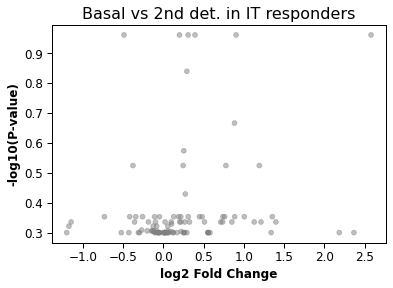

In [35]:
r = 1
df_comp_it_r1 = make_comparison(df_it[df_it['r:response'] == r],
                         title='Basal vs 2nd det. in IT responders',
                         csv_path=f'../results/comparisons/IT1_R{r}.csv',
                         png_path=f'../results/comparisons/IT1_R{r}.png')

### 4.1.4 Basal vs. second determination comparisons in non-responders IT patients

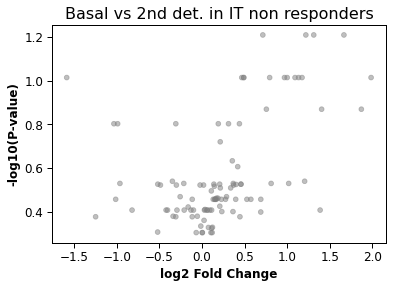

In [29]:
r = 0
df_comp_it_r0 = make_comparison(df_it[df_it['r:response'] == r],
                         title='Basal vs 2nd det. in IT non responders',
                         csv_path=f'../results/comparisons/IT1_R{r}.csv',
                         png_path=f'../results/comparisons/IT1_R{r}.png')

In [31]:
df_comp_it_r0.sort_values(by='p_value')

index   stat   p_value  p_value_nofdrcorrection  \
99               IF:CD19+_CCR9+_   48.0  0.061992                 0.000675   
96               IF:CD56+_CCR9+_   58.0  0.061992                 0.002058   
95            IF:CD3+_CD8+_CCR9+   55.0  0.061992                 0.002431   
84               IF:CD56+_SLAN+_   59.0  0.061992                 0.002284   
0                IF:CD19+_GRK2+_   67.0  0.096953                 0.007142   
..                           ...    ...       ...                      ...   
26   IF:CD11c+CD14+_MHCII+_IL6R+  108.5  0.493528                 0.483782   
30           IF:CD3+_CD8+_CD244+  149.0  0.493528                 0.493528   
31           IF:CD3+_CD8+_beta7+  136.0  0.493528                 0.486302   
40   IF:CD11c+CD14+_MHCII+_CD47+  108.0  0.493528                 0.475686   
44  IF:CD11c+CD14+_MHCII+_ADAM8+  114.0  0.493528                 0.492187   

    -log10(p_value)    log2FC   n_1   n_0  
99         1.207665  1.664929  12.0  24.0  
96         1.207665  1.310973  12.0  24.0  
95         1.207665  1.218221  11.0  25.0  
84         1.207665  0.713680  12.0  24.0  
0          1.013438 -1.586312  12.0  23.0  
..              ...       ...   ...   ...  
26         0.306688 -0.067548  10.0  22.0  
30         0.306688  0.002536  12.0  25.0  
31         0.306688  0.004958  11.0  25.0  
40         0.306688  0.105720  10.0  22.0  
44         0.306688  0.119788  10.0  23.0  

[102 rows x 8 columns]

## 4.2 IT Responders vs IT non responders Fold Change analysis 

It was an experimental analysis because it is not a classical Fold Change analysis. In any case, the comparisons were not found to be statistically significant.

In [39]:
df_if1 = df_it[['I:patient', 'r:response', 'r:treatment_inmunotherapy'] + get_columns(df[get_columns(df, 'IF:', loc='start')], '_1', loc='end')]
df_if2 = df_it[['I:patient', 'r:response', 'r:treatment_inmunotherapy'] + get_columns(df[get_columns(df, 'IF:', loc='start')], '_2', loc='end')]

In [40]:
d = 1
df_comp_it_d1 = make_comparison(df_if1, var='r:response',
                         title='IT responders vs IT non responders basal det.',
                         csv_path=f'../results/comparisons/IT1_D{d}.csv',
                         png_path=f'../results/comparisons/IT1_D{d}.png')

In [52]:
df_comp_it_d1.sort_values(by='p_value_nofdrcorrection')

index   stat   p_value  p_value_nofdrcorrection  \
99  IF:CD11c+CD14+_MHCII+_PSGL1+_1   95.0  0.485512                 0.015770   
5               IF:CD56+_NKG2c+__1  106.5  0.485512                 0.017535   
98              IF:CD56+_NKG2a+__1  110.0  0.485512                 0.022407   
95              IF:CD56+_beta7+__1  120.0  0.485512                 0.042925   
87  IF:CD11c+CD14-_MHCII+_BETA7+_1  115.0  0.485512                 0.044328   
..                             ...    ...       ...                      ...   
57   IF:CD11c+CD14+_MHCII+_IL6R+_1  162.0  0.485512                 0.469173   
40             IF:CD3+_CD8+_PD1+_1  177.0  0.485512                 0.471232   
39            IF:CD3+_CD4+_IL6R+_1  185.5  0.492952                 0.483286   
45               IF:CD56+_CD47+__1  179.0  0.494427                 0.494240   
48           IF:CD3+_CD4+_CD210+_1  186.5  0.494427                 0.494427   

    -log10(p_value)    log2FC   n_1   n_0  
99         0.313800  0.566956  15.0  22.0  
5          0.313800 -1.214870  15.0  24.0  
98         0.313800  0.514801  15.0  24.0  
95         0.313800  0.370646  15.0  24.0  
87         0.313800  0.265170  15.0  23.0  
..              ...       ...   ...   ...  
57         0.313800  0.025765  15.0  22.0  
40         0.313800 -0.069374  15.0  24.0  
39         0.307196 -0.072952  15.0  25.0  
45         0.305898 -0.017966  15.0  24.0  
48         0.305898 -0.007971  15.0  25.0  

[102 rows x 8 columns]

In [111]:
d = 2
df_comp_it_d2 = make_comparison(df_if2, var='r:response',
                         title='IT responders vs IT non responders 2nd det.',
                         csv_path=f'../results/comparisons/IT1_D{d}.csv',
                         png_path=f'../results/comparisons/IT1_D{d}.png')

## 5. Survival analysis <a class="anchor" id="survival-analysis"></a>

Showed in ()

## 6. Modeling <a class="anchor" id="modeling"></a>

In [ ]:
There are several variables with lots of missing values. One of the algorithms 

In [8]:
seed=123

In [9]:
model = ensemble.RandomForestClassifier(n_estimators=400, min_samples_leaf=5, random_state=seed)
features = clinical_variables + basal_markers

In [70]:
pca_x = df_it[features].fillna(df_it[features].median()).drop(get_columns(df, 'r:', loc='start'), axis=1)
x_features = pca_x.columns
pca_y = df_it[features][['r:response']]

x = StandardScaler().fit_transform(pca_x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pca_y], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f'PC1 ({(pca.explained_variance_ratio_[0]*100).round(2)}%)', fontsize = 15)
ax.set_ylabel(f'PC2 ({(pca.explained_variance_ratio_[1]*100).round(2)}%)', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['r:response'] == target
    ax.scatter(finalDf.loc[indicesToKeep, f'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [71]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=x_features)
loadings.sort_values(by='PC1', ascending=False).head(10)

PC1       PC2
IF:CD56+_Tie2+__1                0.192627  0.082110
IF:CD56+_IL15Ra+__1              0.186074  0.111751
IF:CD3+_CD8+_TIM3+_1             0.181038  0.126261
i:irae_type_myositis             0.173700  0.132280
IF:CD3+_CD8+_SLAN+_1             0.171226  0.061685
IF:CD19+_Tie2+__1                0.168861  0.100079
IF:CD11c+CD14+_MHCII+_IL15Ra+_1  0.168281  0.082627
IF:CD3+_CD8+_IFNg+_1             0.168118  0.134532
IF:CD3+_CD8+_IL15Ra+_1           0.161459  0.058362
IF:CD3+_CD4+_IL17+_1             0.161448  0.136009

In [72]:
df_model = df_it[features]
df_model = df_model.dropna(thresh=df_model.shape[1]*0.95)
df_model = df_model.apply(lambda x: x.fillna(x.mean()))

In [73]:
df_model.shape

(37, 187)

In [74]:
features = df_model.drop('r:response', axis=1)
target = df_model['r:response']

In [75]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2, random_state=seed)

In [76]:
model.fit(train_features, train_target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [77]:
print(generate_scores(model, test_features, test_target))

{'Accuracy': 0.875, 'AUC': 0.8333333333333334, 'Average Precision Score': 0.75, 'Balanced Accuracy': 0.75, 'F1 Score': 0.6666666666666666, 'Log Loss': -0.5356612993303917, 'Precision': 1.0, 'Recall': 0.5, 'Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.86      1.00      0.92         6\n         1.0       1.00      0.50      0.67         2\n\n    accuracy                           0.88         8\n   macro avg       0.93      0.75      0.79         8\nweighted avg       0.89      0.88      0.86         8\n', 'Confusion Matrix': array([[6, 0],
       [1, 1]])}


In [78]:
scores = cross_validate(model, 
                        features, target, 
                        cv=StratifiedKFold(n_splits=5, random_state=seed, shuffle=False),
                        scoring=scoring_metrics(),
                        return_train_score=False)
pd.DataFrame(scores)

fit_time  score_time  test_Accuracy  test_AUC  \
0  0.465607    0.067527       0.625000  1.000000   
1  0.433517    0.067785       0.875000  0.933333   
2  0.437264    0.067326       1.000000  1.000000   
3  0.431919    0.066994       0.857143  0.750000   
4  0.432336    0.067768       0.714286  1.000000   

   test_Average Precision Score  test_Balanced Accuracy  test_F1 Score  \
0                      1.000000                0.500000       0.000000   
1                      0.916667                0.900000       0.857143   
2                      1.000000                1.000000       1.000000   
3                      0.833333                0.833333       0.800000   
4                      1.000000                0.666667       0.500000   

   test_Log Loss  test_Precision  test_Recall  
0      -0.472142            0.00     0.000000  
1      -0.550345            0.75     1.000000  
2      -0.424812            1.00     1.000000  
3      -0.608574            1.00     0.666667  
4      -0.526876            1.00     0.333333

-

## 8. Contributing <a class="anchor" id="contributing"></a>

-